2020-05-26 v1 LSW@NCHC

2020-08-13 v2

2020-08-31 v3_tf.data_Loadandpreprocessdata_image_tf2.3to2.2_twcc_clean


### 2020-08-31 <font color=#FF6600>Move to 'clean NB' for trail, leave original NB for course used.</font>

### 2020-09-14 <font color=#FF6600>Fixed BN in fine-tune training, added dropout at top-layer.</font>
### 2020-09-16 <font color=#FF6600>Added tf.distribute.Strategy with multi-GPUs for speedup training.</font>
### 2020-09-17 <font color=#FF6600>Added step learning rate, tensorboard callback.</font>
### 2020-09-18 <font color=#FF6600>Added triple loss.</font>

## 0. Install pkgs for TWCC

In [1]:
!sh install_env.sh

Get:1 http://archive.ubuntu.com/ubuntu bionic InRelease [242 kB]            
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB] 
Get:3 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [1094 kB]3m
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]    
Get:6 http://archive.ubuntu.com/ubuntu bionic/main amd64 Packages [1344 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [10.1 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [116 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 Packages [186 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic/restricted amd64 Packages [13.5 kB]m
Get:11 http://archive.ubuntu.com/ubuntu bionic/universe amd64 Packages [11.3 MB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [903 kB]
Get:13 ht

Selecting previously unselected package tree.
Preparing to unpack .../18-tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Selecting previously unselected package unrar.
Preparing to unpack .../19-unrar_1%3a5.5.8-1_amd64.deb ...
Unpacking unrar (1:5.5.8-1) ...
dpkg: warning: failed to open configuration file '/home/uu/.dpkg.cfg' for reading: Permission denied
Setting up unrar (1:5.5.8-1) ...
update-alternatives: using /usr/bin/unrar-nonfree to provide /usr/bin/unrar (unrar) in auto mode
update-alternatives: warning: skip creation of /usr/share/man/man1/unrar.1.gz because associated file /usr/share/man/man1/unrar-nonfree.1.gz (of link group unrar) doesn't exist
Setting up tree (1.7.0-5) ...
Setting up libpthread-stubs0-dev:amd64 (0.3-4) ...
Setting up xorg-sgml-doctools (1:1.11-1) ...
Setting up libx11-6:amd64 (2:1.6.4-3ubuntu0.3) ...
Setting up x11proto-dev (2018.4-4) ...
Setting up xtrans-dev (1.3.5-1) ...
Setting up x11proto-xext-dev (2018.4-4) ...
Setting up libxdmcp-dev:amd64

  Attempting uninstall: certifi
    Found existing installation: certifi 2020.4.5.2
    Uninstalling certifi-2020.4.5.2:
      Successfully uninstalled certifi-2020.4.5.2
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 118 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 9.5 MB/s  eta 0:00:01
     |████████████████████████████████| 2.2 MB 14.6 MB/s eta 0:00:01


  Created wheel for jupyternotify: filename=jupyternotify-0.1.15-py3-none-any.whl size=8720 sha256=4985c65cc061be3fe8fddad9921b1fe0fa1d4bbdce3913f60fcd595f8df59a60
  Stored in directory: /tmp/pip/wheels/68/5b/f0/bcb83c7c2bb680feb7f4de11f072a3106a0cb9e7752fff19fe
Successfully built jupyternotify
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


## 1. Download dataset

In [1]:
from datetime import datetime

import tensorflow as tf
import tensorflow_addons as tfa

# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import cv2
import vlogging
import io

print("tf version : ", tf.__version__)

# 下載資料,(flower ~218MB)
# keras下載位置預設為~/user/.keras/datasets/
# !ls /Users/lsw/.keras/datasets/flower_photos
# LICENSE.txt daisy  dandelion  roses  sunflowers  tulips

# flood
# origin = 'https://drive.narlabs.org.tw/webrelay/directdownload/txp8hb31v67tl47f/?dis=10014&fi=2683826'
# data_dir = tf.keras.utils.get_file(origin=origin, fname='floods', untar=True)

# flood with local dir
# data_dir = '/home/uu/.keras/datasets/floods' #不下載，直接sftp上傳

# flowers
# origin = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
# data_dir = tf.keras.utils.get_file(origin=origin, fname='flower_photos', untar=True)

# uni
data_dir = '/home/uu/.keras/datasets/uni' #不下載，直接sftp上傳



data_dir = pathlib.Path(data_dir) # 注意！這把原本路徑轉換成PosixPath的物件=PosixPath('~/user/.keras/datasets/')不是原始的string路徑。
image_count = len(list(data_dir.glob('*/*.jpg')))
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" and not item.name.startswith('.')])
# todo:這裡可以幫學員回憶python強大的表示式處理


# data information
print("Save to :", data_dir)
print("Count images: ", image_count)
print("Class names : ", CLASS_NAMES)

tf version :  2.2.0
Save to : /home/uu/.keras/datasets/uni
Count images:  5620
Class names :  ['ng' 'ok']


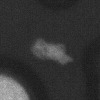

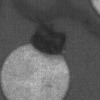

In [2]:
# 檢查資料夾內圖片

roses = list(data_dir.glob('ng/*'))

for image_path in roses[:2]:
    display.display(Image.open(str(image_path)))

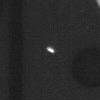

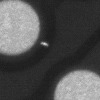

In [3]:
# 檢查資料夾內圖片

roses = list(data_dir.glob('ok/*'))

for image_path in roses[:2]:
    display.display(Image.open(str(image_path)))

In [4]:
# vars
BATCH_SIZE = 32 #32 
img_height = 100 #224 224
img_width = 100
# STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

#IMG_SIZE = (224, 224) # IMG_SIZE = (160, 160)

## 2. Load dataset with tf.data


In [5]:
# 以tf.data來讀取資料
# 同樣地，給定本地資料集的路徑。
# 2020-06-11版本(相同)
"""tf.data.Dataset.list_files
Note: The default behavior of this method is to return filenames in 
a non-deterministic random shuffled order. Pass a seed or shuffle=False 
to get results in a deterministic order.預設為random shuffle"""

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [6]:
# 檢查路徑、檔案

for f in list_ds.take(10):
  print(f.numpy())

b'/home/uu/.keras/datasets/uni/ng/CSPAFI#4_19CC2018-04-000_3_NG003_Panel0010_ProcA3_Shot0_V22_D0_Img.jpg'
b'/home/uu/.keras/datasets/uni/ng/CSPAFI-C#3_19CJ2027-02-000_1_NG004_Panel0003_ProcA4_Col#2_Shot0_V13_D1_Img.jpg'
b'/home/uu/.keras/datasets/uni/ok/CSPAFI#4_19CC2018-04-000_3_NG006_Panel0019_ProcA4_Shot0_V13_D0_Img.jpg'
b'/home/uu/.keras/datasets/uni/ok/CSPAFI#6_19CC2018-02-000_1_NG009_Panel0002_ProcA4_Shot0_V24_D0_Img.jpg'
b'/home/uu/.keras/datasets/uni/ok/CSPAFI-C#3_19CJ2027-02-000_2_NG002_Panel0008_ProcA3_Col#1_Shot0_V16_D2_Img.jpg'
b'/home/uu/.keras/datasets/uni/ng/CSPAFI-C#3_19CC2018-04-000_1_NG003_Panel0010_ProcA4_Col#2_Shot0_V0_D0_Img.jpg'
b'/home/uu/.keras/datasets/uni/ok/CSPAFI#4_19CC2018-04-000_3_NG001_Panel0003_ProcA3_Shot0_V16_D0_Img.jpg'
b'/home/uu/.keras/datasets/uni/ng/CSPAFI-C#3_19CJ2027-02-000_1_NG001_Panel0020_ProcA4_Col#2_Shot0_V26_D0_Img.jpg'
b'/home/uu/.keras/datasets/uni/ng/CSPAFI-C#3_19CJ2027-02-000_2_NG003_Panel0014_ProcA4_Col#2_Shot0_V25_D2_Img.jpg'
b'/home

hit: 觀察有無shuffle變化

In [7]:
#增加了對類別排序而已sorted ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']

class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['ng' 'ok']


hit: 這裏可以請同學練習list基本原理與操作，往後資料呈現都會是以多維list or array方式。

hit:列表產生式與產生器的不同，`[] and ()`使用差異。

### Split the dataset into train and validation:

In [8]:
# train 80, val 20
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)



In [9]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

4498
1124


In [10]:
for t,v in zip(train_ds.take(2),val_ds.take(2)):
  print(t.numpy(), '\n')
  print(v.numpy())


b'/home/uu/.keras/datasets/uni/ng/CSPAFI#6_19CJ2028-02-000_1_NG005_Panel0003_ProcA3_Shot0_V8_D0_Img.jpg' 

b'/home/uu/.keras/datasets/uni/ng/CSPAFI#4_19CC2018-04-000_3_NG003_Panel0010_ProcA3_Shot0_V22_D0_Img.jpg'
b'/home/uu/.keras/datasets/uni/ok/CSPAFI#6_19CC2018-05-000_1_NG010_Panel0022_ProcA3_Shot0_V14_D1_Img.jpg' 

b'/home/uu/.keras/datasets/uni/ng/CSPAFI-C#3_19CJ2027-02-000_1_NG004_Panel0003_ProcA4_Col#2_Shot0_V13_D1_Img.jpg'


In [11]:
#J Save train/val path list for later used

# len(list(val_ds))#1124 images for val_ds

count = 0
for element in val_ds.take(2):
    print(element) #tf.Tensor(b'/home/uu/.keras/datasets/uni/ng/CSPAFI#6_19CC2018-05-000_1_NG011_Panel0006_ProcA3_Shot0_V5_D0_Img.jpg', shape=(), dtype=string)
    parts = tf.strings.split(element, os.path.sep)
    print('parts[] =', parts[-2]) # [-2]= dir name, [-1]= file name.
    count += 1   
print(count)
    

tf.Tensor(b'/home/uu/.keras/datasets/uni/ng/CSPAFI#4_19CC2018-04-000_3_NG003_Panel0010_ProcA3_Shot0_V22_D0_Img.jpg', shape=(), dtype=string)
parts[] = tf.Tensor(b'ng', shape=(), dtype=string)
tf.Tensor(b'/home/uu/.keras/datasets/uni/ng/CSPAFI-C#3_19CJ2027-02-000_1_NG004_Panel0003_ProcA4_Col#2_Shot0_V13_D1_Img.jpg', shape=(), dtype=string)
parts[] = tf.Tensor(b'ng', shape=(), dtype=string)
2


### Converts a file path to an (img, label) pair:

In [12]:
#J tf2.3新版load_data/images使用one-hot, 所以後面的training 要把sparse_categorical_crossentropy換掉，變傳統的one-hot/categorical loss.
#新版：tf2.3
#
#J modify the get_label for runing at tf2.2 2020-08-06 2020-08-11 OKfortf2.2
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num
#     return tf.argmax(one_hot)
#   return tf.math.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label



# hit: 請學員參考寫註解(英文)的方式，清晰易讀。中文註解主要作為課程說明與程式註解用途不同。

In [13]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds_map = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_map = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)



one_num: Tensor("ArgMax:0", shape=(), dtype=int64)
one_num: Tensor("ArgMax:0", shape=(), dtype=int64)


## 3. 使用tf.data訓練模型
### Basic methods for training

To train a model with this dataset you will want the data:

- To be well shuffled.
- To be batched.
- Batches to be available as soon as possible.

These features can be added using the tf.data API. For more details, see the Input Pipeline Performance guide.
https://render.githubusercontent.com/guide/performance/datasets



hit: 基本套路 洗牌 batch 正規化


In [14]:
#J
#新版：簡化很多
# def configure_for_performance(ds):
#   ds = ds.cache()
#   ds = ds.shuffle(buffer_size=1000)
#   ds = ds.batch(BATCH_SIZE)
#   ds = ds.prefetch(buffer_size=AUTOTUNE)
#   return ds

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

MULTI_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync

print('BATCH_SIZE: {}, MULTI_BATCH_SIZE: {}'.format(BATCH_SIZE, MULTI_BATCH_SIZE))

def configure_for_performance_cache(ds, cache=True):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
      print("Check cache to file:", cache)
    else:
      ds = ds.cache()
      print("Check cache in memory:", cache)
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
BATCH_SIZE: 32, MULTI_BATCH_SIZE: 128


hit:

    ds.shuffle(buffer_size=1000)
    表示buffer維持一千張圖，隨機抽掉一張後，會由1001張補進維持1K張。因此完美的洗牌建議buffer要大於或等於dataset數量。

In [15]:
#J 新版：
train_ds_pre = configure_for_performance_cache(train_ds_map)
val_ds_pre = configure_for_performance_cache(val_ds_map)


Check cache in memory: True
Check cache in memory: True


### Visualize the data
You can visualize this dataset similarly to the one you created previously.

label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)


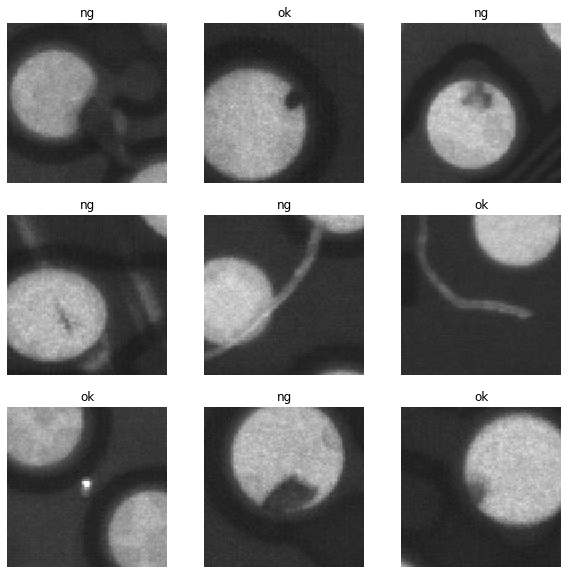

In [16]:
#J 新版：tf2.3

image_batch, label_batch = next(iter(train_ds_pre))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  print('label from label_batch:', label)
  plt.title(class_names[label])
  plt.axis("off")

In [17]:
#====================================================================================================#

In [18]:
#====================================================================================================#

In [19]:
#====================================================================================================#

In [20]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


In [21]:
tf.config.experimental.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [22]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 4


In [ ]:
#====================================================================================================#

In [ ]:
#====================================================================================================#

# <font color=#FF6600>Transfer Learning with triple loss.</font>

## Multi GPUs model : Only Top Layer (Transfer Learning with triple loss)

tf.distribute.MirroredStrategy()

In [42]:
#strategy => move to tf.data session for check gloable batch size.

model_name = 'Xception' #'InceptionV3' "ResNet50" #'EfficientNetB7' for tf2.3

IMG_SHAPE = (img_height, img_width) + (3,)

base_learning_rate = 0.0001 # org. 0.0001 = 1e-4

num_classes = 2


with strategy.scope():
    
    base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
    # Freeze the base_model
    base_model.trainable = False
    
    # FIXIT in future. added fake inputs for let BN works.
    inputs = tf.keras.Input(shape=(IMG_SHAPE))
    bm_output = base_model(inputs, training=False)
    gap2d = tf.keras.layers.GlobalAveragePooling2D()(bm_output)
    dropout = tf.keras.layers.Dropout(0.2)(gap2d)#J add dropout
#     outputs = tf.keras.layers.Dense(num_classes)(dropout)
    flat = tf.keras.layers.Flatten()(dropout)
    dens = tf.keras.layers.Dense(256, activation=None)(flat) # No activation on final dense layer
#     L2N = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dens) # L2 normalize embeddings
    outputs = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dens) # L2 normalize embeddings
    
    #這裡把triplet L2N輸出256 vector，改回原本的分類問題
#     outputs = tf.keras.layers.Dense(num_classes)(L2N)

    model = tf.keras.Model(inputs, outputs, name=model_name)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tfa.losses.TripletSemiHardLoss()#,
              #metrics=['accuracy']
                 )
    
    

In [43]:
%%time
initial_epochs = 300
history = model.fit(train_ds_pre,
                    epochs=initial_epochs,
                    validation_data=val_ds_pre
                   )

Epoch 1/300
36/36 [==============================] - 10s 274ms/step - loss: 0.9809 - accuracy: 0.4384 - val_loss: 0.9260 - val_accuracy: 0.4297
Epoch 2/300
36/36 [==============================] - 9s 257ms/step - loss: 0.8700 - accuracy: 0.4302 - val_loss: 0.7793 - val_accuracy: 0.4164
Epoch 3/300
36/36 [==============================] - 1s 28ms/step - loss: 0.7865 - accuracy: 0.3997 - val_loss: 0.7228 - val_accuracy: 0.3959
Epoch 4/300
36/36 [==============================] - 1s 25ms/step - loss: 0.7370 - accuracy: 0.3826 - val_loss: 0.6747 - val_accuracy: 0.3826
Epoch 5/300
36/36 [==============================] - 1s 26ms/step - loss: 0.7022 - accuracy: 0.3666 - val_loss: 0.6442 - val_accuracy: 0.3719
Epoch 6/300
36/36 [==============================] - 1s 26ms/step - loss: 0.6901 - accuracy: 0.3499 - val_loss: 0.6128 - val_accuracy: 0.3532
Epoch 7/300
36/36 [==============================] - 1s 25ms/step - loss: 0.6822 - accuracy: 0.3348 - val_loss: 0.6080 - val_accuracy: 0.3443
Epo

36/36 [==============================] - 1s 26ms/step - loss: 0.5899 - accuracy: 0.2030 - val_loss: 0.4822 - val_accuracy: 0.2028
Epoch 59/300
36/36 [==============================] - 1s 37ms/step - loss: 0.5877 - accuracy: 0.2079 - val_loss: 0.4997 - val_accuracy: 0.2064
Epoch 60/300
36/36 [==============================] - 1s 27ms/step - loss: 0.5880 - accuracy: 0.2074 - val_loss: 0.5140 - val_accuracy: 0.2073
Epoch 61/300
36/36 [==============================] - 1s 31ms/step - loss: 0.5811 - accuracy: 0.2085 - val_loss: 0.5070 - val_accuracy: 0.2064
Epoch 62/300
36/36 [==============================] - 1s 25ms/step - loss: 0.5881 - accuracy: 0.2003 - val_loss: 0.5564 - val_accuracy: 0.2046
Epoch 63/300
36/36 [==============================] - 1s 25ms/step - loss: 0.5821 - accuracy: 0.2052 - val_loss: 0.5134 - val_accuracy: 0.2064
Epoch 64/300
36/36 [==============================] - 1s 25ms/step - loss: 0.5868 - accuracy: 0.2005 - val_loss: 0.4972 - val_accuracy: 0.2055
Epoch 65/300

KeyboardInterrupt: 

In [40]:
# Evaluate the network
results = model.predict(val_ds_pre)

In [34]:
results

array([[ 1.4192854 ,  0.9931044 ],
       [-0.8043801 , -0.6890271 ],
       [ 1.1428846 , -0.7378397 ],
       ...,
       [ 1.0945661 ,  0.2484742 ],
       [-1.6120209 , -0.91509473],
       [ 1.662421  ,  0.5347276 ]], dtype=float32)

In [41]:
# Evaluate the network
model.evaluate(val_ds_pre)

9/9 [==============================] - 0s 15ms/step - loss: 0.5355 - accuracy: 0.1806


[0.5355279445648193, 0.1806049793958664]

In [26]:
# Save test embeddings for visualization in projector
np.savetxt("triple-vecs.tsv", results, delimiter='\t')

# out_m = io.open('meta.tsv', 'w', encoding='utf-8')
# for img, labels in tfds.as_numpy(val_ds_pre):
#     [out_m.write(str(x) + "\n") for x in labels]
# out_m.close()
out_m = io.open('triple-meta.tsv', 'w', encoding='utf-8')
for image_batch, label_batch in val_ds_pre: 
#     for i in range(BATCH_SIZE):
    [out_m.write(str(class_names[x.numpy()]) + "\n") for x in label_batch]
out_m.close()




try:
  from google.colab import files
  files.download('triple-vecs.tsv')
  files.download('triple-meta.tsv')
except:
  pass

# <font color=#FF6600>Fine Tuning with triple loss.</font> 

## <font color=#FF6600>Multi GPUs model : Top-100 Layers (Fine tuning ONLY without transfer learning.) </font>


tf.distribute.MirroredStrategy() Fine tuning

### Un-freeze the top layers of the model

In [44]:
#strategy => move to tf.data session for check gloable batch size.

model_name = 'Xception' #'InceptionV3' "ResNet50" #'EfficientNetB7' for tf2.3

IMG_SHAPE = (img_height, img_width) + (3,)

base_learning_rate = 0.0001 # org. 0.0001 = 1e-4 #改成程序化依epoch減少lr即可，沒有先做transfer leaning的必要.
# lr = 1e-6
lr=base_learning_rate#/1000
print("lr_base = {:.12f}\nlr_tune = {:.12f}\n".format(base_learning_rate, lr))


num_classes = 2

# Fine-tune from this layer onwards
fine_tune_at = 100# this is LAYER position NOT epoch!!!


with strategy.scope():
    
    base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
    # Un-freeze the top layers of the model
    base_model.trainable = True
    
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False

    
    # FIXIT in future. added fake inputs for let BN works.
    inputs = tf.keras.Input(shape=(IMG_SHAPE))
    bm_output = base_model(inputs, training=False)
    gap2d = tf.keras.layers.GlobalAveragePooling2D()(bm_output)
    dropout = tf.keras.layers.Dropout(0.2)(gap2d)#J add dropout, 0.2 is ok.
#     outputs = tf.keras.layers.Dense(num_classes)(dropout)
    
    flat = tf.keras.layers.Flatten()(dropout)
    dens = tf.keras.layers.Dense(784, activation=None)(flat) # No activation on final dense layer
    outputs = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dens) # L2 normalize embeddings
    
    model = tf.keras.Model(inputs, outputs, name=model_name)

# The transfer learning setup
#     model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#               loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# The fine tune and multi-GPUs and LearningRateScheduler setup
    model.compile(optimizer = tf.keras.optimizers.RMSprop(),# adm -> RMSprop??, original is /10 may to /100 to reduce the overfitting
              loss=tfa.losses.TripletSemiHardLoss() #tf.losses.SparseCategoricalCrossentropy(from_logits=True),              
              #metrics=['accuracy']
                 )

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

lr_base = 0.000100000000
lr_tune = 0.000100000000

Number of layers in the base model:  132


In [45]:
# Function for decaying the learning rate.
# You can define any decay function you need.

# simple step decay
# def decay(epoch):
#   if epoch < 100:
#     return 1e-3
#   elif epoch >= 100 and epoch < 200:
#     return 1e-4
#   elif epoch >= 200 and epoch < 300:
#     return 1e-5
#   elif epoch >= 300 and epoch < 400:
#     return 1e-6
#   else:
#     return 1e-7

# # exponential decay
# def decay(epoch):
#    k = 0.05
#    t = epoch * 0.02
#    lrate = base_learning_rate * np.exp(-k*t) # t is iteration number.

#    #tf.summary.scalar('learning rate', data=lrate, step=epoch)# for tb plot.
#    return lrate


# step decay
def decay(epoch):
   initial_lrate = base_learning_rate
   drop = 0.8
   epochs_drop = 10.0
   lrate = initial_lrate * tf.math.pow(drop, tf.math.floor((1+epoch)/epochs_drop))
#    #tf.summary.scalar('learning rate', data=lrate, step=epoch)# for tb plot.
   return lrate


LR decay curve
e0    lr: tf.Tensor(1e-04, shape=(), dtype=float32)
e100  lr: tf.Tensor(1.073742e-05, shape=(), dtype=float32)
e500  lr: tf.Tensor(1.4272487e-09, shape=(), dtype=float32)
e1000 lr: tf.Tensor(2.037039e-14, shape=(), dtype=float32)
e2000 lr: tf.Tensor(4.149528e-24, shape=(), dtype=float32)


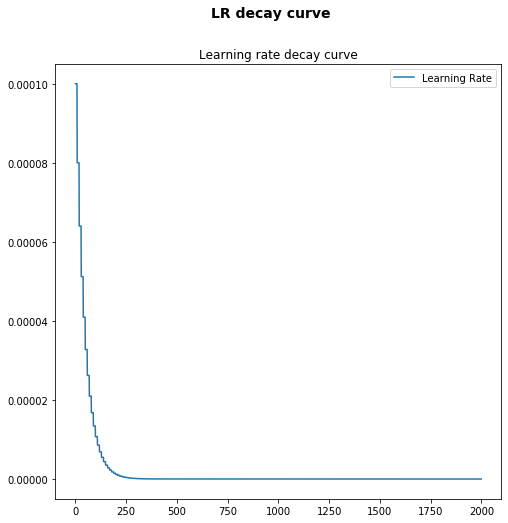

In [46]:
fig = plt.figure(figsize=(8, 8), num=model_name)
fig.suptitle("LR decay curve", fontsize=14, fontweight='bold')
print("LR decay curve")

num_epoch = range(2000)
num_lr = []
for epoch in range(2000):
    num_lr.append(decay(epoch))
#     print(decay(epoch))

plt.plot(num_epoch, num_lr, label='Learning Rate')
# plt.ylim([0.000000000001, 1])
plt.legend(loc='upper right')
plt.title('Learning rate decay curve')

print("e0    lr:", num_lr[0])
print("e100  lr:", num_lr[100])
print("e500  lr:", num_lr[500])
print("e1000 lr:", num_lr[1000])
print("e2000 lr:", num_lr[2000 - 1])

In [47]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

In [48]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#self lr save
# file_writer = tf.summary.create_file_writer(logdir + "/metrics")
# file_writer.set_as_default()


In [49]:
callbacks = [
#     tf.keras.callbacks.TensorBoard(log_dir='./logs'),
#     tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
#                                        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100), #monitor='loss' or monitor='val_loss', stop after 20 epoch no improve.
    tf.keras.callbacks.LearningRateScheduler(decay),
    #PrintLR(),
    tensorboard_callback
]

In [50]:
len(model.trainable_variables)

41

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [52]:
%%time
fine_tune_epochs = 300
total_epochs =  fine_tune_epochs #initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds_pre,
                         epochs=total_epochs,
                         #initial_epoch=history.epoch[-1],
                         #validation_data=val_ds_pre,
                         #callbacks=callbacks
                        )

Epoch 1/300
36/36 [==============================] - 1s 28ms/step - loss: 0.6506
Epoch 2/300
36/36 [==============================] - 1s 29ms/step - loss: 0.6407
Epoch 3/300
36/36 [==============================] - 1s 28ms/step - loss: 0.6293
Epoch 4/300
36/36 [==============================] - 1s 30ms/step - loss: 0.6173
Epoch 5/300
36/36 [==============================] - 1s 27ms/step - loss: 0.6175
Epoch 6/300
36/36 [==============================] - 1s 27ms/step - loss: 0.6726
Epoch 7/300
36/36 [==============================] - 1s 27ms/step - loss: 0.6137
Epoch 8/300
36/36 [==============================] - 1s 27ms/step - loss: 0.5945
Epoch 9/300
36/36 [==============================] - 1s 27ms/step - loss: 0.5812
Epoch 10/300
36/36 [==============================] - 1s 27ms/step - loss: 0.5693
Epoch 11/300
36/36 [==============================] - 1s 27ms/step - loss: 0.5680
Epoch 12/300
36/36 [==============================] - 1s 27ms/step - loss: 0.5516
Epoch 13/300
36/36 [=====

36/36 [==============================] - 1s 27ms/step - loss: 0.0382
Epoch 102/300
36/36 [==============================] - 1s 27ms/step - loss: 0.0593
Epoch 103/300
36/36 [==============================] - 1s 27ms/step - loss: 0.0411
Epoch 104/300
36/36 [==============================] - 1s 27ms/step - loss: 0.0441
Epoch 105/300
36/36 [==============================] - 1s 26ms/step - loss: 0.0453
Epoch 106/300
36/36 [==============================] - 1s 26ms/step - loss: 0.0570
Epoch 107/300
36/36 [==============================] - 1s 27ms/step - loss: 0.0707
Epoch 108/300
36/36 [==============================] - 1s 26ms/step - loss: 0.0508
Epoch 109/300
36/36 [==============================] - 1s 27ms/step - loss: 0.0446
Epoch 110/300
36/36 [==============================] - 1s 27ms/step - loss: 0.0528
Epoch 111/300
36/36 [==============================] - 1s 26ms/step - loss: 0.0506
Epoch 112/300
36/36 [==============================] - 1s 27ms/step - loss: 0.0651
Epoch 113/300
36/3

36/36 [==============================] - 1s 27ms/step - loss: 0.0180
Epoch 200/300
36/36 [==============================] - 1s 26ms/step - loss: 0.0288
Epoch 201/300
36/36 [==============================] - 1s 26ms/step - loss: 0.0262
Epoch 202/300
36/36 [==============================] - 1s 37ms/step - loss: 0.0262
Epoch 203/300
36/36 [==============================] - 1s 27ms/step - loss: 0.0129
Epoch 204/300
36/36 [==============================] - 1s 36ms/step - loss: 0.0021
Epoch 205/300
36/36 [==============================] - 1s 26ms/step - loss: 0.0174
Epoch 206/300
36/36 [==============================] - 1s 26ms/step - loss: 0.0142
Epoch 207/300
36/36 [==============================] - 1s 25ms/step - loss: 0.0021
Epoch 208/300
36/36 [==============================] - 1s 27ms/step - loss: 0.0340
Epoch 209/300
36/36 [==============================] - 1s 26ms/step - loss: 0.0201
Epoch 210/300
36/36 [==============================] - 1s 39ms/step - loss: 0.0052
Epoch 211/300
36/3

36/36 [==============================] - 1s 27ms/step - loss: 0.0102
Epoch 298/300
36/36 [==============================] - 1s 29ms/step - loss: 0.0129
Epoch 299/300
36/36 [==============================] - 1s 27ms/step - loss: 0.0044
Epoch 300/300
36/36 [==============================] - 1s 26ms/step - loss: 0.0031
CPU times: user 16min 18s, sys: 1min 30s, total: 17min 48s
Wall time: 5min 44s


In [54]:
# Evaluate the network
results = model.predict(val_ds_pre)

In [55]:
# Save test embeddings for visualization in projector
np.savetxt("uni_triple-vecs_loss0.0031.tsv", results, delimiter='\t')

# out_m = io.open('meta.tsv', 'w', encoding='utf-8')
# for img, labels in tfds.as_numpy(val_ds_pre):
#     [out_m.write(str(x) + "\n") for x in labels]
# out_m.close()
out_m = io.open('uni_triple-meta_loss0.0031.tsv', 'w', encoding='utf-8')
for image_batch, label_batch in val_ds_pre: 
#     for i in range(BATCH_SIZE):
    [out_m.write(str(class_names[x.numpy()]) + "\n") for x in label_batch]
out_m.close()




# try:
#   from google.colab import files
#   files.download('triple-vecs_01.tsv')
#   files.download('triple-meta_01.tsv')
# except:
#   pass